In [1]:
# importing required libraries
import numpy as np 
import pandas as pd 

# tensorflow layers
from tensorflow.keras.layers import LSTM, Input, Embedding, Bidirectional, Activation, Dense, Dropout
# metrics
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix
# preprocessing libraries
import nltk

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import Counter
from nltk.corpus import stopwords

import re
import string

from tensorflow.keras.models import Model
# visualization
import seaborn as sns 
from tensorflow.keras.preprocessing import sequence
from nltk.stem import PorterStemmer 
from tensorflow.keras.preprocessing.text import Tokenizer


In [2]:
from sklearn.model_selection import train_test_split
# visualizations
import matplotlib.cm as cm
from mlxtend.plotting import plot_confusion_matrix
from nltk.tokenize import RegexpTokenizer
# auc roc curve
from sklearn.metrics import roc_curve, auc

In [3]:
from matplotlib import rcParams
# wordcloud
from wordcloud import WordCloud
import nltk
from tensorflow.keras.optimizers import RMSprop
# nltk.download('wordnet')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# visualizations
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter

In [2]:
# importing data using pandas
data = pd.read_csv(r'tweet_emotions.csv')

In [3]:
# printing the first five rows of data 
data.tail()

,tweet_id,sentiment,content
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...


In [6]:
# column names
data.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [7]:
# selecting the columns requred for analysis
data = data[['sentiment','content']]

In [8]:
# data
data.tail()

,sentiment,content
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,love,@mopedronin bullet train from tokyo the gf ...


In [9]:
data.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [10]:
# changing the output labels as others 
data['sentiment'] = data['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'neutral'] else "other")

# data visualization 

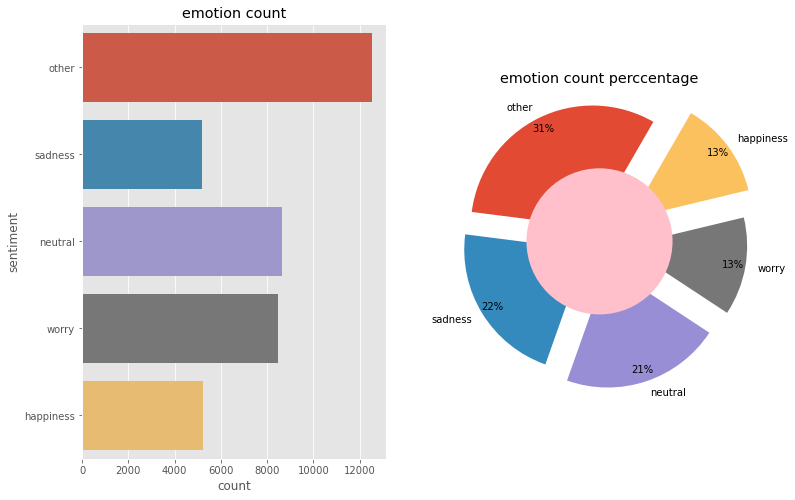

In [11]:
# data exploration 
# visualizing output columns 
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
list_values = list((np.array(list(data['sentiment'].dropna().value_counts()))/sum(list(data['sentiment'].dropna().value_counts())))[::-1])[:10]
# labels 
label = list(data['sentiment'].dropna().unique())[:10]
# value count
val = data['sentiment'].value_counts()[:10]
# pie plot showing percentages of leabel counts
ax2.pie(val,  explode=list_values, startangle=60, labels=label,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='pink'))
# count plot to show output labels
sns.countplot(y ='sentiment', data = data, ax=ax1)
ax1.set_title("emotion count")
ax2.set_title("emotion count perccentage")
plt.show()

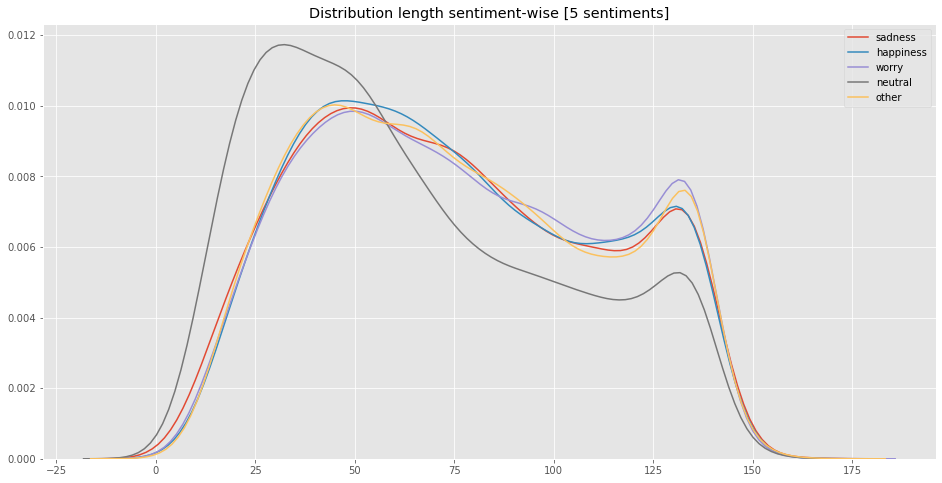

In [12]:
# adding a column to store lenghts of each row
data['char_length'] = data['content'].apply(lambda x : len(x))
fig, ax = plt.subplots(figsize=(16,8))
for sent in data['sentiment'].value_counts().sort_values()[-5:].index.tolist():
#  plotting density vs character plot 
    sns.kdeplot(data[data['sentiment']==sent]['char_length'],ax=ax, label=sent)
ax.legend()
ax.set_title("Distribution length sentiment-wise [5 sentiments]")
plt.show()

In [13]:
# encoding the multilabel output
from sklearn.preprocessing import LabelEncoder
# object 
enco = LabelEncoder()
# fitting the label encoder 
data['sentiment'] = enco.fit_transform(data[['sentiment']].values)

In [14]:
data.tail()

,sentiment,content,char_length
39995,1,@JohnLloydTaylor,16
39996,2,Happy Mothers Day All my love,30
39997,2,Happy Mother's Day to all the mommies out ther...,123
39998,0,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,122
39999,2,@mopedronin bullet train from tokyo the gf ...,132


In [15]:
# taking a fraction of data 
data = data.sample(frac=.5, random_state=14)

In [16]:
# importing NLTK library for text process
import nltk
# nltk.download('stopwords')

# data preprocessing

In [17]:
# data preprocessing inspired and referenced from: https://github.com/KevinYobeth/Python-TextEmotionDetection

# importing stopwords
from nltk.corpus import stopwords
# creating a corpus of stopwords 
#These are words in any language that do not contain any meaningful information concerning the phrase in which they are used. For a text classification task, they can be safely omitted as they do not supply relevant information to the model 
set_stopwords = set(stopwords.words('english'))
# cleaning stopwords from data
def stop_words_(text):
    return " ".join([word for word in str(text).split() if word not in set_stopwords])
# fitting the function to data
data['content'] = data['content'].apply(lambda text: stop_words_(text))
data['content'].head()

34504                               raining Denver. COURSE
7568     #followfriday @RoRuby although doesnt consider...
18916    Crazy Legs peepin @nina_parks pool hahaha She ...
7137     lookin 4ward 2 work 2mz.. n gna b like 2day-we...
11398    hanging around house. Thank god friday. With n...
Name: content, dtype: object

In [18]:
# removing the punctuations from the text data
eng_punct = string.punctuation
# function to remove the punctuations
#punctuation does not carry meaningful information and is removed from all the datasets. 
def punct_clean(text):
    output = str.maketrans('', '', eng_punct)
    return text.translate(output)
# fitting the function 
data['content'] = data['content'].apply(lambda x: punct_clean(x))
data['content'].head()

34504                                raining Denver COURSE
7568     followfriday RoRuby although doesnt consider s...
18916    Crazy Legs peepin ninaparks pool hahaha She li...
7137     lookin 4ward 2 work 2mz n gna b like 2dayweath...
11398    hanging around house Thank god friday With nin...
Name: content, dtype: object

In [19]:
# function to remove special characters from the text
#special characters and numbers are also removed from the text. 
def clean_character(text):
    return re.sub(r'(.)\1+', r'\1',text)
data['content'] = data['content'].apply(lambda x: clean_character(x))
data['content'].head()

34504                                raining Denver COURSE
7568     folowfriday RoRuby although doesnt consider sw...
18916    Crazy Legs pepin ninaparks pol hahaha She like...
7137     lokin 4ward 2 work 2mz n gna b like 2dayweathe...
11398    hanging around house Thank god friday With nin...
Name: content, dtype: object

In [20]:
# function to remove special characters like email address from the text
def clean_email(text):
    return re.sub('@[^\s]+','',text)
data['content'] = data['content'].apply(lambda x: clean_email(x))
data['content'].tail()

36715    watered tomato plants peper plants letuce feli...
30777                        geramie yeah I thinking ahaha
5333                                            bad grades
27606    please please please please let match canceled...
3186                                       way slepy awake
Name: content, dtype: object

In [21]:
# function to remove web url's from the text
def clean_url(text):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
data['content'] = data['content'].apply(lambda x: clean_url(x))
data['content'].tail()

36715    watered tomato plants peper plants letuce feli...
30777                        geramie yeah I thinking ahaha
5333                                            bad grades
27606    please please please please let match canceled...
3186                                       way slepy awake
Name: content, dtype: object

In [22]:
# function to remove numbers from the text
#Numbers are removed because they do not add much information to text processing.
def clean_nums(text):
    return re.sub('[0-9]+', '',text)
data['content'] = data['content'].apply(lambda x: clean_nums(x))
data['content'].tail()

36715    watered tomato plants peper plants letuce feli...
30777                        geramie yeah I thinking ahaha
5333                                            bad grades
27606    please please please please let match canceled...
3186                                       way slepy awake
Name: content, dtype: object

In [23]:
# tokenizer 
# RegexpTokeniser: A tokenizer that partitions a string into tokens using a regular expression
#Tokenisation is the process of converting the raw text into small tokens such as characters or words. These tokens aid in comprehending the context by preparing a vocabulary and in constructing the NLP models. 
tokenizer = RegexpTokenizer(r'\w+')
data['content'] = data['content'].apply(tokenizer.tokenize)

In [24]:
# cleasned data 
data.head()

,sentiment,content,char_length
34504,4,"[raining, Denver, COURSE]",44
7568,4,"[folowfriday, RoRuby, although, doesnt, consid...",69
18916,1,"[Crazy, Legs, pepin, ninaparks, pol, hahaha, S...",93
7137,3,"[lokin, ward, work, mz, n, gna, b, like, daywe...",90
11398,0,"[hanging, around, house, Thank, god, friday, W...",121


In [25]:
# stemming
# Stemming is a technique for reducing a term to its stem or root form. It is often used in content extraction tasks to improve recall and provide the most relevant results.
stemming = nltk.PorterStemmer()
# converting the words into its root or base form by the process of stemming
def stemming_data(data):
    out = [stemming.stem(word) for word in data]
    return out
data['content'] = data['content'].apply(lambda x: stemming_data(x))
data['content'].head()

34504                                [rain, denver, cours]
7568     [folowfriday, rorubi, although, doesnt, consid...
18916    [crazi, leg, pepin, ninapark, pol, hahaha, she...
7137     [lokin, ward, work, mz, n, gna, b, like, daywe...
11398    [hang, around, hous, thank, god, friday, with,...
Name: content, dtype: object

In [26]:
# Lemmatization is the process of determining a word's normalised form. It is analogous to searching for a transformation to apply to a word to get its normalised version. This normalised form is the dictionary or canonical form and is known as the lemma in the lemmatisation process. the words context. As a result, it connects words with similar meanings into a single term.
Lemmatizer = nltk.WordNetLemmatizer()
# function to perform lemmatization over the data
def lemmatize(data):
    text = [Lemmatizer.lemmatize(word) for word in data]
    return text
data['content'] = data['content'].apply(lambda x: lemmatize(x))
data['content'].head()

34504                                [rain, denver, cours]
7568     [folowfriday, rorubi, although, doesnt, consid...
18916    [crazi, leg, pepin, ninapark, pol, hahaha, she...
7137     [lokin, ward, work, mz, n, gna, b, like, daywe...
11398    [hang, around, hous, thank, god, friday, with,...
Name: content, dtype: object

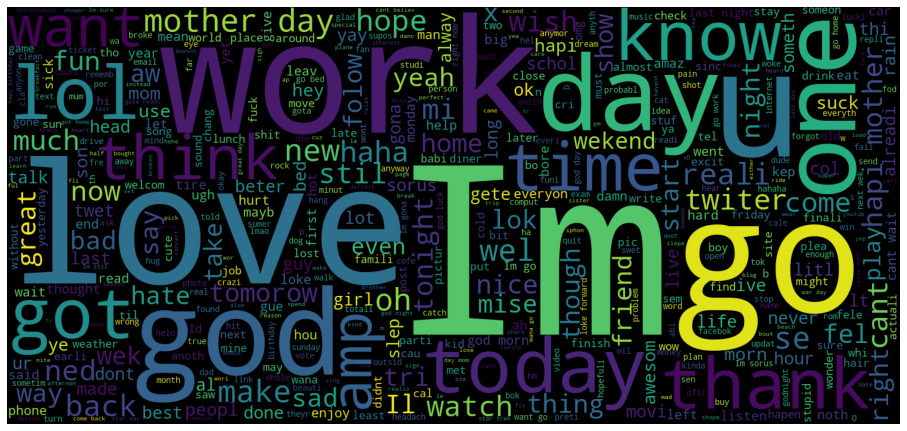

In [27]:
# creating a corpus for word cloud
#Word clouds are graphic representations of words that give a greater size to words that occur more often more importance.
word_cloud=[]
for val in data['content']:
    for i in val:
        word_cloud.append(i)
# joining words in the corpus
words=" ".join(word_cloud)        
cloud = WordCloud(background_color='black', width=1500,                            
                      height=700, max_words=500).generate(words)
# plotting the word cloud
fig, ax = plt.subplots(figsize=(16,9))            
ax.imshow(cloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(cloud) 

In [28]:
# splitting the data into input  and output
X = data.content
# input data
X.head()

34504                                [rain, denver, cours]
7568     [folowfriday, rorubi, although, doesnt, consid...
18916    [crazi, leg, pepin, ninapark, pol, hahaha, she...
7137     [lokin, ward, work, mz, n, gna, b, like, daywe...
11398    [hang, around, hous, thank, god, friday, with,...
Name: content, dtype: object

In [29]:
# labels
Y = data['sentiment']
Y.head()

34504    4
7568     4
18916    1
7137     3
11398    0
Name: sentiment, dtype: int32

In [30]:
# converting the encoded values into dummies
Y = pd.get_dummies(data['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (20000, 5)


In [31]:
# converting data into vectors
max_length = 500
token = Tokenizer(num_words=2000)
token.fit_on_texts(X)
#When training models and producing predictions, the sequence imposes an order on the data that must be maintained.
#padding converts these inputs into fixed-length inputs for the models. Sequences from the TensorFlow module of python is used for padding.
sequence_s = token.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequence_s,maxlen=max_length)

In [32]:
# data preparation- train test split
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, Y, test_size=0.2, random_state=2)

# designing the network 

In [33]:
#Defined tensorflow based modelfuntion to train the data
def tensorflow_model(): 
    # Input layer
    input_s = Input(shape=(max_length,))
    mylayer = Embedding(2000,50,input_length=max_length)(input_s) 
    #The next layer added is the LSTM layer with the unit equal to 64. The units represent the dimensionality of the output space
    mylayer = LSTM(64)(mylayer) 
    # hidden layer
    #The units or the dimensionality of output space is kept at 256 which means that this layer has 256 neurons
    mylayer = Dense(256,name='FC1')(mylayer) 
    mylayer = Activation('relu')(mylayer)
    # output layer
    mylayer = Dropout(0.5)(mylayer) 
    # output  containing 5 neurons as we need to classify emotions
    mylayer = Dense(5,name='out_layer')(mylayer) 
    # softmax activation function used for multilabel output
    mylayer = Activation('softmax')(mylayer) 
    # final output value in the model for classification
    model = Model(inputs=input_s,outputs=mylayer) 
    #function returning model 
    return model 

In [34]:
# creating the object and compiling the model
model = tensorflow_model() 
# configuring the LSTM model for training
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

# Trainig the model

In [ ]:
# fitting the model to the data
LSTM_model=model.fit(X_train,Y_train,batch_size=32,epochs=10, validation_split=0.2)# here we are starting the training of model by feeding the training data
print('Training finished !!')

In [36]:
# metrics to check the performance of the model
from sklearn.metrics import classification_report, cohen_kappa_score
import numpy

y_pred = model.predict(X_test)
# the out put values are decimal so changing them to binary
y_pred = numpy.round(y_pred > 0.5)
y_pred = y_pred.astype(int)
label = ['happiness', 'sadness', 'worry', 'neutral',"other"]
print(classification_report(Y_test, y_pred, target_names=label))

              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00       502
     sadness       0.51      0.05      0.10       847
       worry       0.64      0.13      0.21      1234
     neutral       0.50      0.00      0.00       548
       other       0.68      0.02      0.03       869

   micro avg       0.61      0.05      0.10      4000
   macro avg       0.47      0.04      0.07      4000
weighted avg       0.52      0.05      0.09      4000
 samples avg       0.05      0.05      0.05      4000



In [37]:
from sklearn.metrics import multilabel_confusion_matrix
cn = multilabel_confusion_matrix(Y_test, y_pred)
cn

array([[[3498,    0],
        [ 502,    0]],

       [[3109,   44],
        [ 801,   46]],

       [[2676,   90],
        [1077,  157]],

       [[3451,    1],
        [ 547,    1]],

       [[3124,    7],
        [ 854,   15]]], dtype=int64)

In [38]:
cn[0]

array([[3498,    0],
       [ 502,    0]], dtype=int64)

## Visualizing Confusion matrix

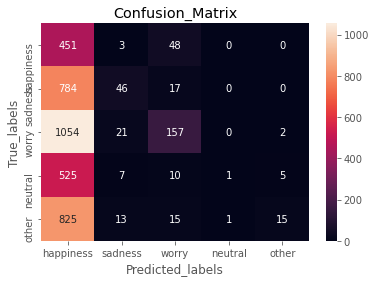

In [39]:

import seaborn as sns

my_labels_multiclass = ['happiness', 'sadness', 'worry', 'neutral',"other"]    

ax= plt.subplot()

c_m = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(c_m, annot=True, fmt='g', ax=ax);
ax.set_xlabel('Predicted_labels');ax.set_ylabel('True_labels'); 
#confusion matrix
ax.set_title('Confusion_Matrix'); 
ax.xaxis.set_ticklabels(my_labels_multiclass); ax.yaxis.set_ticklabels(my_labels_multiclass);

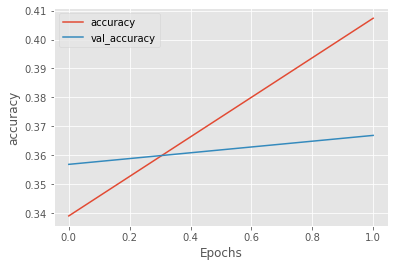

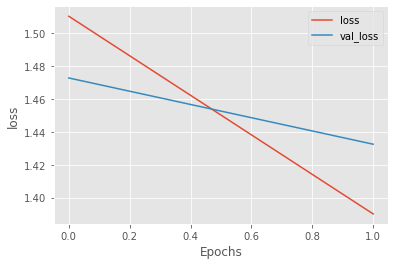

In [40]:
# funtion to plot model's validation accuracy and validarion loss
#referenced from stack overflow
def plots(hist, strng):
    plt.plot(LSTM_model.history[strng])
    plt.plot(LSTM_model.history['val_'+strng])
    plt.ylabel(strng)
    plt.xlabel("Epochs")
    plt.legend([strng, 'val_'+strng])
    plt.show()
# comparing validation loss and training loss to check whethere the model is performing well. Check for underfit and overfit
plots(LSTM_model, "accuracy")
plots(LSTM_model, "loss")

### evaluating the model using Matthews correlation coefficient 

In [41]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

0.07812176072552295

In [42]:
acc = model.evaluate(X_test,Y_test) # evaluating the model

125/125 [==============================] - 6s 49ms/step - loss: 1.3981 - accuracy: 0.3923 0s - los


In [43]:
print('Test Accuracy: {:0.2f}'.format(acc[1]))

Test Accuracy: 0.39


In [44]:
from tensorflow.keras.layers import Embedding

# Bidirectional LSTM 

In [45]:
# libraries for bidirectioanl LSTM
from tensorflow.keras.models import Sequential
#importing layers
from tensorflow.keras import layers
# regularizers for adding noise
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
# Y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))
#Defining a function to build a tensorflow based model
def tensorflow_model(): 
    # Infput layer
    input_s = Input(shape=(max_length,))
    My_layer = Embedding(2000,50,input_length=max_length)(input_s) 
    My_layer = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3,input_shape = (5,10)))(My_layer) 
    # hideen layer
    My_layer = Dense(256,name='FC1')(My_layer) 
    My_layer = Activation('relu')(My_layer) 
    # adding regularization using dropout algorithm so that model does not overf fit
    My_layer = Dropout(0.5)(My_layer)
    # output  containing 5 neurons as we need to classify emotions
    My_layer = Dense(5,name='out_layer')(My_layer) 
    # softmax activation function used for multilabel output
    My_layer = Activation('softmax')(My_layer) 
    # final output value in the model for classification
    model = Model(inputs=input_s,outputs=My_layer) 
    return model 

In [46]:
# creating an object for the model
model = tensorflow_model() # here we are calling the function of created model
# configuring the LSTM model for training
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
# fitting model with 5 epochs and 32 batch size
BiLSTM_model=model.fit(X_train,Y_train,batch_size=32,epochs=2, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/2
450/450 [==============================] - 307s 675ms/step - loss: 1.5140 - accuracy: 0.3360 - val_loss: 1.4641 - val_accuracy: 0.3694
Epoch 2/2
450/450 [==============================] - 347s 772ms/step - loss: 1.4081 - accuracy: 0.3978 - val_loss: 1.4400 - val_accuracy: 0.3744
Training finished !!


In [47]:
# metrics for evaluating the model
from sklearn.metrics import classification_report, cohen_kappa_score
# predictions on the model
y_pred = model.predict(X_test) 
y_pred = (y_pred > 0.5)
labels = ['happiness', 'sadness', 'worry', 'neutral',"other"]
print(classification_report(Y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

   happiness       0.00      0.00      0.00       502
     sadness       0.60      0.00      0.01       847
       worry       0.56      0.18      0.27      1234
     neutral       0.50      0.01      0.02       548
       other       0.57      0.01      0.02       869

   micro avg       0.56      0.06      0.11      4000
   macro avg       0.45      0.04      0.06      4000
weighted avg       0.49      0.06      0.09      4000
 samples avg       0.06      0.06      0.06      4000



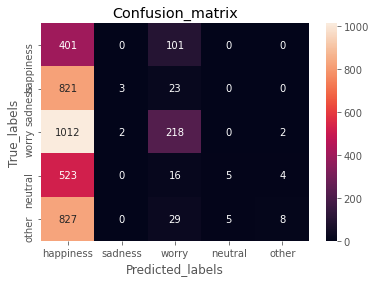

In [48]:
# visualizing confusion matrix
import seaborn as sns

my_labels_BiLSTM = ['happiness', 'sadness', 'worry', 'neutral',"other"]    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);# annote to remove scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted_labels');ax.set_ylabel('True_labels'); 
ax.set_title('Confusion_matrix'); 
ax.xaxis.set_ticklabels(my_labels_BiLSTM); ax.yaxis.set_ticklabels(my_labels_BiLSTM);

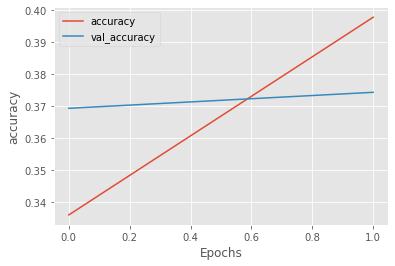

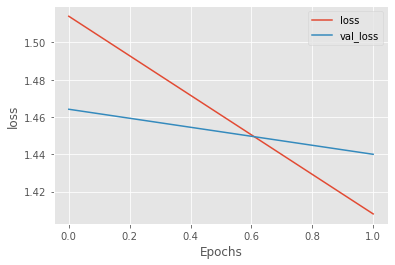

In [49]:
# funtion to plot model
#referenced from stack overflow
def plots(model, strng):
    plt.plot(model.history[strng])
    plt.plot(model.history['val_'+strng])
    plt.xlabel("Epochs")
    plt.ylabel(strng)
    plt.legend([strng, 'val_'+strng])
    plt.show()
  
plots(BiLSTM_model, "accuracy")
plots(BiLSTM_model, "loss")

In [50]:
matthews_corrcoef(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))

0.0394627227182262

In [51]:
from mcc_f1 import mcc_f1_curve, plot_mcc_f1_curve